In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from datetime import datetime

# Setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [12]:
df = pd.read_csv("Fixed_cleaned_activities.csv")
df["Begin Timestamp"] = pd.to_datetime(df["Begin Timestamp"], errors="coerce")
df = df.dropna(subset=["Begin Timestamp"])
df["Hour"] = df["Begin Timestamp"].dt.hour

# Label Time of Day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    else:
        return "Evening"

# Apply label
df["Time of Day"] = df["Hour"].apply(get_time_of_day)

# Drop outliers (optional advanced): Z-score method
numeric_cols = ["Average Speed", "Average Heart Rate (bpm)", "Average Cadence", "Calories"]
df = df[(np.abs(stats.zscore(df[numeric_cols])) < 3).all(axis=1)]

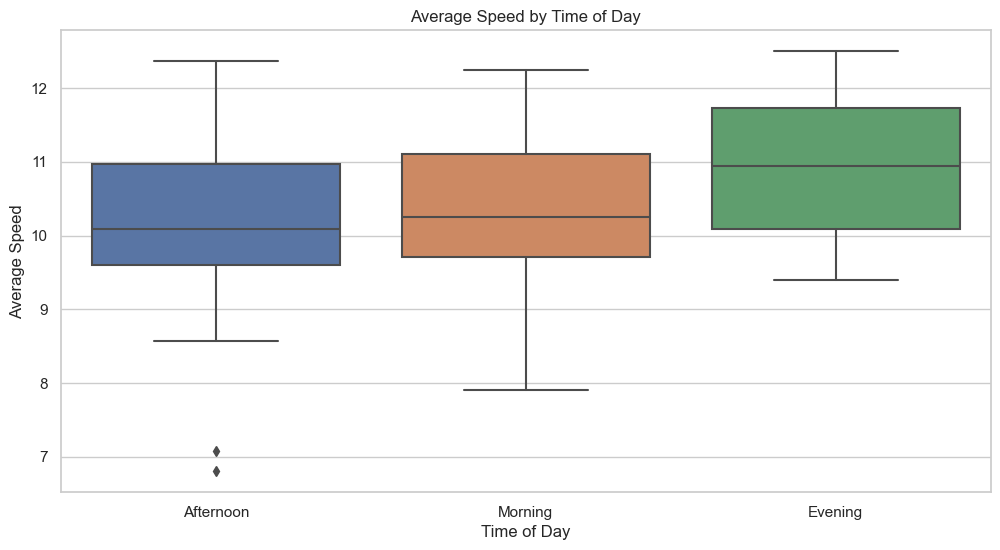

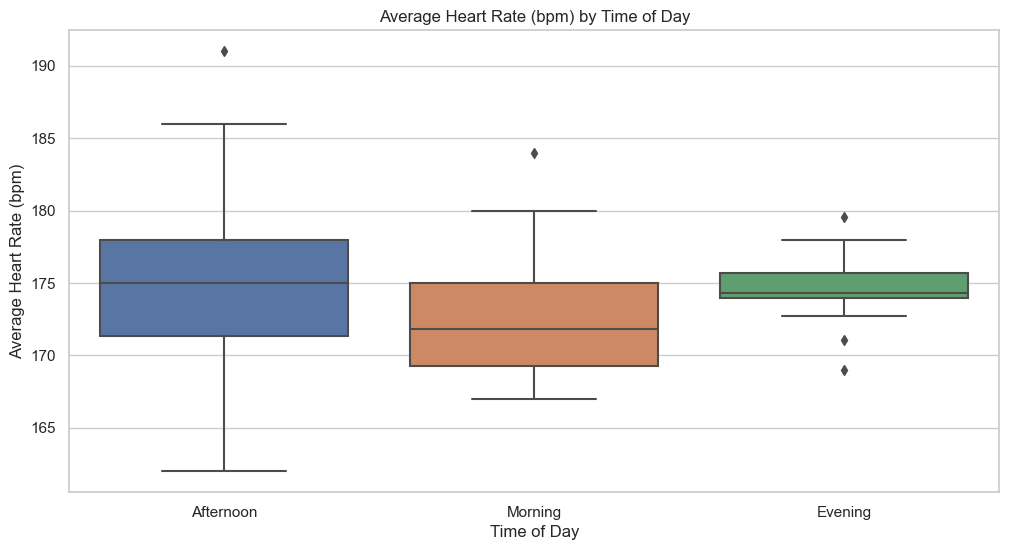

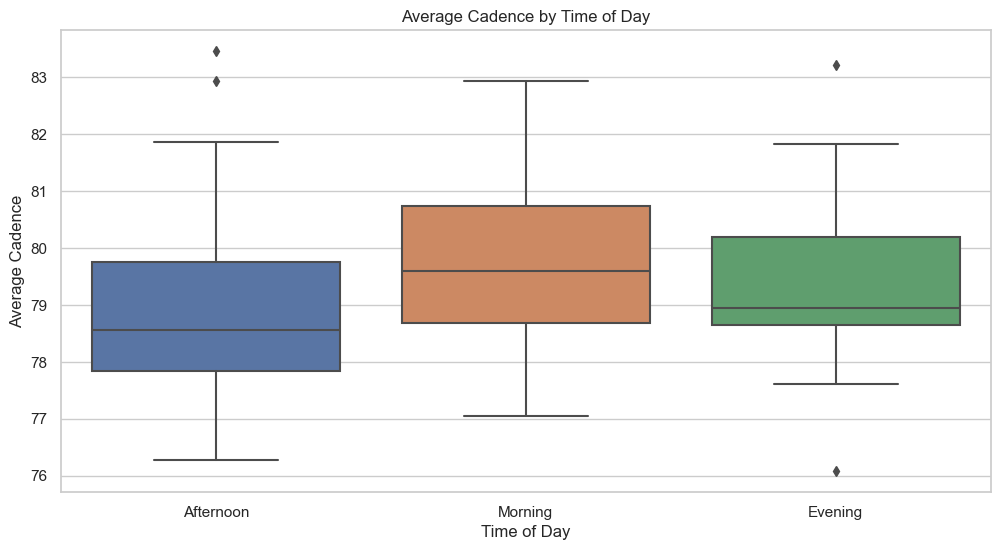

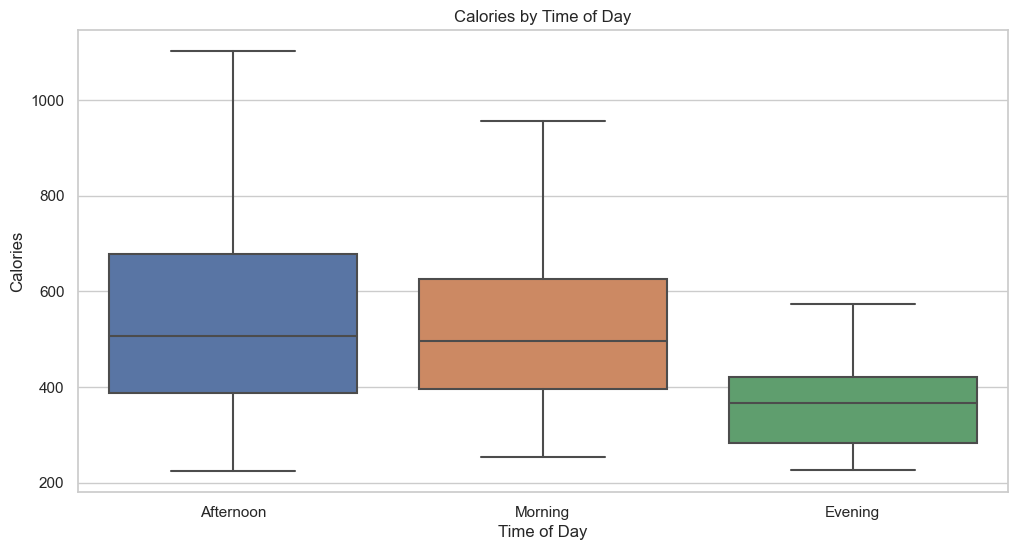

In [13]:
metrics = ["Average Speed", "Average Heart Rate (bpm)", "Average Cadence", "Calories"]

# Boxplots
for metric in metrics:
    sns.boxplot(data=df, x="Time of Day", y=metric)
    plt.title(f"{metric} by Time of Day")
    plt.show()

In [21]:
"""Observation: Evening runs yielded the highest median speed with the most consistent performance, while morning sessions followed closely with slightly lower speed but better heart rate efficiency and cadence. Afternoon runs showed the greatest variability, with the widest spread in both heart rate and cadence, and included the highest calorie burn, likely due to longer or more intense efforts. Morning runs had the lowest average heart rate, indicating better cardiovascular efficiency, whereas evening sessions maintained stable heart rate values with fewer extremes. Overall, morning is optimal for efficiency and consistency, afternoon for calorie burn, and evening for peak speed performance."""


'Observation: Evening runs yielded the highest median speed with the most consistent performance, while morning sessions followed closely with slightly lower speed but better heart rate efficiency and cadence. Afternoon runs showed the greatest variability, with the widest spread in both heart rate and cadence, and included the highest calorie burn, likely due to longer or more intense efforts. Morning runs had the lowest average heart rate, indicating better cardiovascular efficiency, whereas evening sessions maintained stable heart rate values with fewer extremes. Overall, morning is optimal for efficiency and consistency, afternoon for calorie burn, and evening for peak speed performance.'

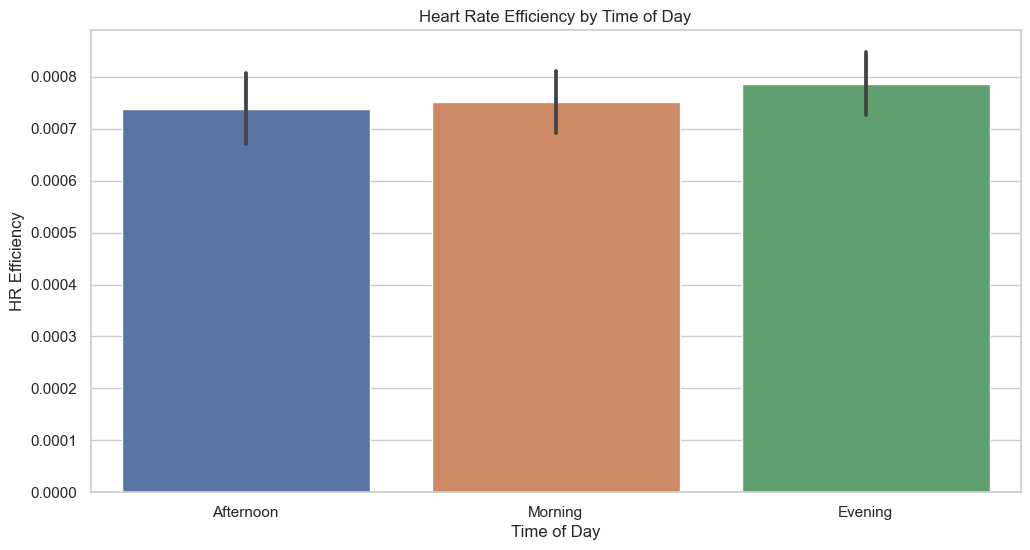

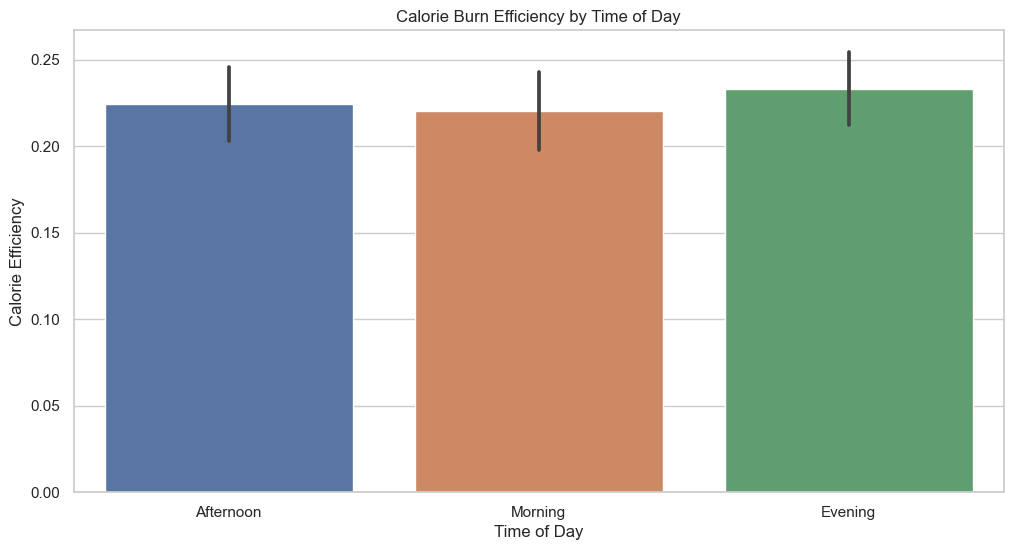

In [14]:
df["HR Efficiency"] = df["Average Speed"] / (df["Average Heart Rate (bpm)"] * df["Average Cadence"])
df["Calorie Efficiency"] = df["Calories"] / df["Duration (seconds)"]

# Visualize
sns.barplot(data=df, x="Time of Day", y="HR Efficiency", ci="sd")
plt.title("Heart Rate Efficiency by Time of Day")
plt.show()

sns.barplot(data=df, x="Time of Day", y="Calorie Efficiency", ci="sd")
plt.title("Calorie Burn Efficiency by Time of Day")
plt.show()


In [22]:
"""Observation: Heart rate efficiency was highest in the evening, slightly outperforming morning and afternoon sessions, suggesting that runners maintained higher speeds with less cardiovascular strain during that time. Calorie burn efficiency was also highest in the evening, followed by afternoon and morning, indicating that evening sessions provided the most effective energy expenditure relative to duration. The differences across time periods were relatively small, but consistent patterns suggest that evening workouts may offer a slight edge in both cardiovascular and energy efficiency."""

'Heart rate efficiency was highest in the evening, slightly outperforming morning and afternoon sessions, suggesting that runners maintained higher speeds with less cardiovascular strain during that time. Calorie burn efficiency was also highest in the evening, followed by afternoon and morning, indicating that evening sessions provided the most effective energy expenditure relative to duration. The differences across time periods were relatively small, but consistent patterns suggest that evening workouts may offer a slight edge in both cardiovascular and energy efficiency.'

In [15]:
for metric in ["Average Speed", "HR Efficiency", "Calorie Efficiency"]:
    morning = df[df["Time of Day"] == "Morning"][metric]
    afternoon = df[df["Time of Day"] == "Afternoon"][metric]
    evening = df[df["Time of Day"] == "Evening"][metric]
    f_stat, p_val = stats.f_oneway(morning, afternoon, evening)
    print(f"ANOVA for {metric}: F = {f_stat:.3f}, p = {p_val:.4f}")


ANOVA for Average Speed: F = 3.586, p = 0.0302
ANOVA for HR Efficiency: F = 3.653, p = 0.0284
ANOVA for Calorie Efficiency: F = 2.154, p = 0.1198


Random Forest Classification Report:
              precision    recall  f1-score   support

   Afternoon       0.53      0.56      0.55        16
     Evening       1.00      0.25      0.40         4
     Morning       0.33      0.40      0.36        10

    accuracy                           0.47        30
   macro avg       0.62      0.40      0.44        30
weighted avg       0.53      0.47      0.47        30

Confusion Matrix:
[[9 0 7]
 [2 1 1]
 [6 0 4]]


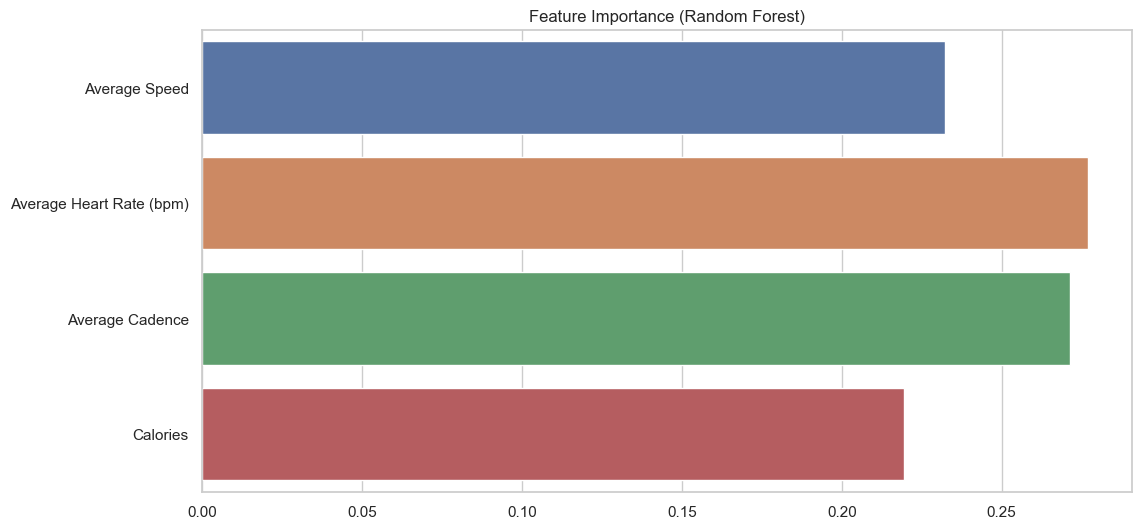

In [16]:
features = ["Average Speed", "Average Heart Rate (bpm)", "Average Cadence", "Calories"]
X = df[features]
y = df["Time of Day"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
sns.barplot(x=rf.feature_importances_, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()


In [23]:
"""The Random Forest model achieved an overall accuracy of 47 percent in predicting the time of day based on average speed, heart rate, cadence, and calories. It performed moderately for afternoon runs with a precision of 0.53 and recall of 0.56, but struggled with morning and evening sessions, especially the latter which had perfect precision but very low recall, indicating it over-predicted evening runs in some cases but failed to capture most actual evening instances. The confusion matrix shows frequent misclassification between morning and afternoon. Among the features, average heart rate and cadence were the most important predictors, while speed and calories had slightly less influence. These results suggest that while performance metrics hold some predictive power, they may not be sufficient alone to reliably determine the time of day without additional contextual data."""

'The Random Forest model achieved an overall accuracy of 47 percent in predicting the time of day based on average speed, heart rate, cadence, and calories. It performed moderately for afternoon runs with a precision of 0.53 and recall of 0.56, but struggled with morning and evening sessions, especially the latter which had perfect precision but very low recall, indicating it over-predicted evening runs in some cases but failed to capture most actual evening instances. The confusion matrix shows frequent misclassification between morning and afternoon. Among the features, average heart rate and cadence were the most important predictors, while speed and calories had slightly less influence. These results suggest that while performance metrics hold some predictive power, they may not be sufficient alone to reliably determine the time of day without additional contextual data.'

In [17]:
def recommend_time(goal):
    if goal == "calories":
        return df.groupby("Time of Day")["Calories"].mean().idxmax()
    elif goal == "speed":
        return df.groupby("Time of Day")["Average Speed"].mean().idxmax()
    elif goal == "efficiency":
        return df.groupby("Time of Day")["HR Efficiency"].mean().idxmax()
    else:
        return "Unknown goal"

goal = "efficiency"
recommendation = recommend_time(goal)
print(f"📢 For goal '{goal}', the recommended time of day to run is: {recommendation}")


📢 For goal 'efficiency', the recommended time of day to run is: Evening


In [25]:
"""Conclusion: Based on the recommendation system developed in this project, evening emerged as the optimal time to run when the user's goal is to maximize efficiency, specifically measured through heart rate efficiency. By analyzing average performance metrics across different times of day, the model evaluated which period consistently produced the highest mean values for calories burned, speed, and efficiency. The outcome reinforces previous findings in the analysis, where evening runs showed advantages in speed and efficiency, making it the most favorable time slot for performance-oriented training."""

"Conclusion: Based on the recommendation system developed in this project, evening emerged as the optimal time to run when the user's goal is to maximize efficiency, specifically measured through heart rate efficiency. By analyzing average performance metrics across different times of day, the model evaluated which period consistently produced the highest mean values for calories burned, speed, and efficiency. The outcome reinforces previous findings in the analysis, where evening runs showed advantages in speed and efficiency, making it the most favorable time slot for performance-oriented training."